In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz, filtfilt

import math 
import json
import datetime
import calendar

from scipy.stats import linregress, kurtosis, skew
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; } .CodeMirror pre {font-size: 9pt;}</style>"))

In [ ]:
rec_start_times = [1658173560000]
rec_end_times  =  [1658173908000]

nrecs = len(rec_start_times)
print(nrecs)
nrounds = 5

trial_len = 30000
sample_interval = 20

rest_len = [42, 31, 38, 39, 31, 17]

1


In [ ]:
recs = []
re_recs = []

for i in range(nrecs):
  df = pd.read_csv('./'+str(rec_start_times[i])+'.'+str(rec_end_times[i])+'.csv')
  df = df.drop_duplicates(subset=['timestamp'])
  recs.append(df)

  # create resampled dataframe rdf
  df['datetime'] = pd.to_datetime(df.timestamp, unit='ms')
  df.set_index('datetime', inplace=True)
  # display(df)

  rdf = pd.concat([df, df.asfreq('1ms')]).sort_index()
  rdf = rdf[~rdf.index.duplicated(keep='first')]
  rdf.interpolate(method='linear', axis=0, inplace=True)
  
  rdf.drop(rdf[(rdf.timestamp < rec_start_times[i]-10000) | (rdf.timestamp > rec_end_times[i])].index, inplace=True)
  rdf.drop(rdf[rdf.timestamp%sample_interval != 0].index, inplace=True)
  rdf.timestamp -= rec_start_times[i]
  rdf.hbo *= 10**13
  rdf.hbr *= 10**13
  rdf.hbt *= 10**13
  
  # display(rdf)
  re_recs.append(rdf)

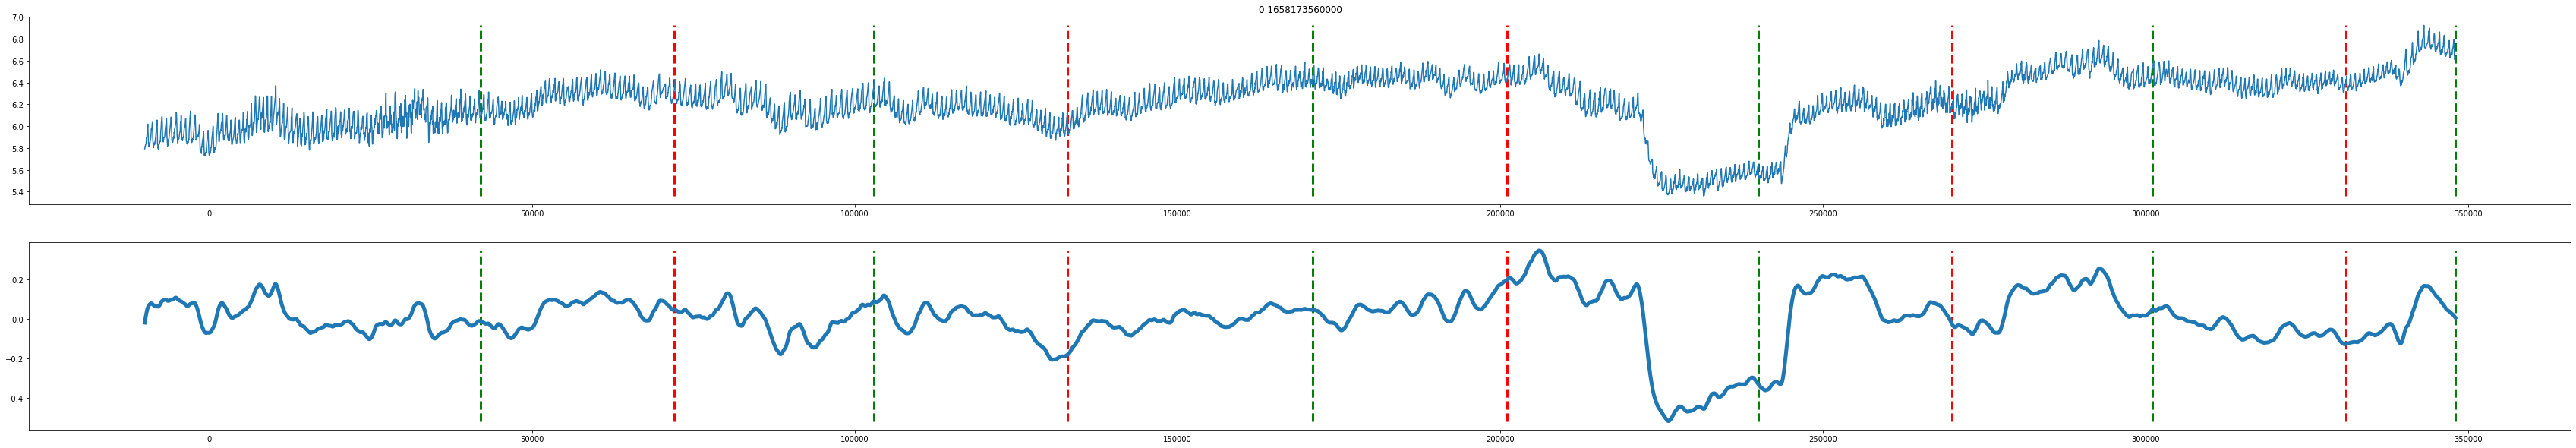

In [ ]:
pd.options.mode.chained_assignment = None
def filter(data, lowcut, highcut):
  fs = 50 # 50 Hz  (20ms intervals)
  order = 2

  nyq = 0.5 * fs
  low = lowcut / nyq
  high = highcut / nyq
  b, a = butter(order, [low, high], btype='band') 
  y = filtfilt(b, a, data)
  return y

def filter_df(df, lowcut, highcut):
  df['hbo_filt'] = filter(df['hbo'], lowcut, highcut) 
  df['hbr_filt'] = filter(df['hbr'], lowcut, highcut) 
  df['hbt_filt'] = filter(df['hbt'], lowcut, highcut) 
  
  df['740nm10mm_filt'] = filter(df['740nm10mm'], lowcut, highcut) 
  df['740nm27mm_filt'] = filter(df['740nm27mm'], lowcut, highcut) 

  df['850nm10mm_filt'] = filter(df['850nm10mm'], lowcut, highcut) 
  df['850nm27mm_filt'] = filter(df['850nm27mm'], lowcut, highcut) 

  df['940nm10mm_filt'] = filter(df['940nm10mm'], lowcut, highcut) 
  df['940nm27mm_filt'] = filter(df['940nm27mm'], lowcut, highcut) 

  return(df)

fig, ax = plt.subplots(2,nrecs,figsize=(60, nrecs*10))
math_trials = []
rest_trials = []

lines = [42, 72, 103, 133, 171, 201, 240, 270, 301, 331, 348]
lines = [l*1000 for l in lines]



rdf = filter_df(re_recs[0], 0.01, 0.5)

ax[0].set_title(str(i) + " " + str(rec_start_times[i]))
ax[0].plot(rdf.timestamp, rdf['hbo'])
ax[0].vlines(lines[::2], rdf['hbo'].min(), rdf['hbo'].max(), linestyles='dashed', colors='green', linewidth=3)
ax[0].vlines(lines[1::2], rdf['hbo'].min(), rdf['hbo'].max(), linestyles='dashed', colors='red', linewidth=3)

ax[1].plot(rdf.timestamp, rdf['hbo_filt'], linewidth=5)
ax[1].vlines(lines[::2], rdf['hbo_filt'].min(), rdf['hbo_filt'].max(), linestyles='dashed', colors='green', linewidth=3)
ax[1].vlines(lines[1::2], rdf['hbo_filt'].min(), rdf['hbo_filt'].max(), linestyles='dashed', colors='red', linewidth=3)